In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Dense, Activation, Conv1D, Dropout, Add, Lambda, Flatten, Input, BatchNormalization

In [ ]:
from keras.layers import Concatenate, Input, Conv1D, BatchNormalization, Dropout, Add, Activation, Lambda, Dense, Softmax
from keras.models import Model
import tensorflow as tf

def TCN_concatenated(nb_classes, Chans=1, Samples=256, layers=1, kernels=[3, 5, 7], filt=10, dropout=0, activation='elu'):
    input1 = Input(shape = (Samples, Chans))
    tcn_outputs = []

    for kernel_size in kernels:

        x = Conv1D(filt, kernel_size=kernel_size, dilation_rate=1, activation=activation, padding='causal', kernel_initializer='he_uniform')(input1)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
        x = Conv1D(filt, kernel_size=kernel_size, dilation_rate=1, activation=activation, padding='causal', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)


        conv = Conv1D(filt, kernel_size=1, padding='same')(input1)
        added = Add()([x, conv])
        out = Activation(activation)(added)
        out = Lambda(lambda x: x[:,-1,:])(out)

        tcn_outputs.append(out)


    concatenated = Concatenate()(tcn_outputs)

    concatenated = BatchNormalization()(concatenated)
    concatenated = Dropout(dropout)(concatenated)

    dense = Dense(nb_classes, name='dense')(concatenated)
    softmax = Activation('softmax', name='softmax')(dense)


    model = Model(inputs=input1, outputs=softmax)

    return model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving second-hand-149907.mp3 to second-hand-149907.mp3


In [ ]:
!pip install librosa

In [ ]:
import librosa

# Load the audio file
audio_path = '/content/second-hand-149907.mp3'
y, sr = librosa.load(audio_path)

In [ ]:
print("Audio data shape:", y.shape)

Audio data shape: (160128,)


In [ ]:
import librosa.display

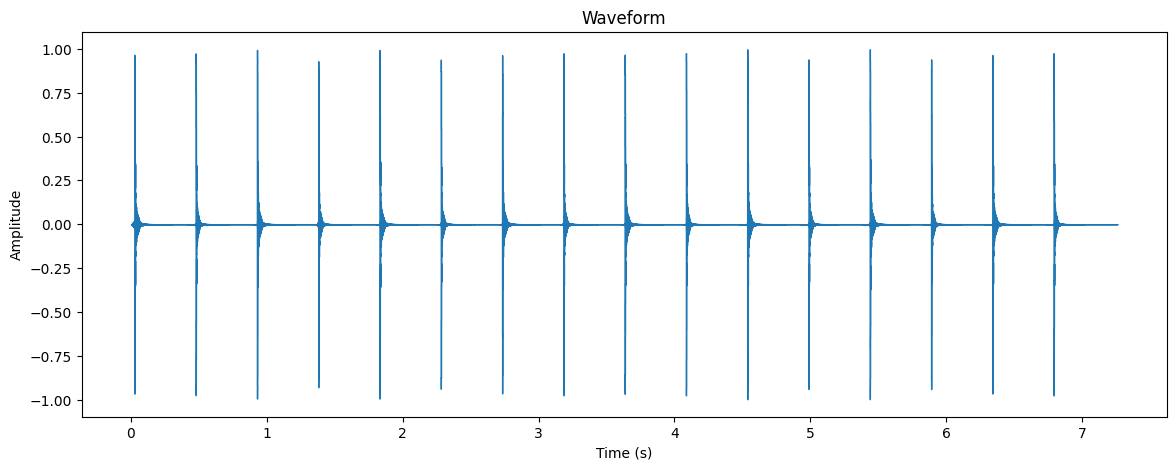

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

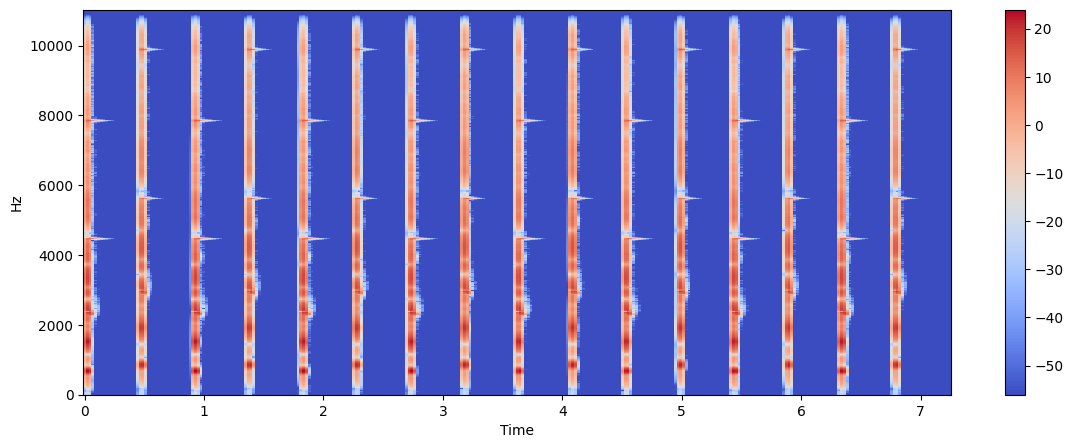

In [ ]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
import numpy as np
spectrogram = np.abs(librosa.stft(Ydb))

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=313
  warnings.warn(


In [ ]:
print(spectrogram.shape)

(1025, 1025, 1)


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import os

# Function to convert audio file to spectrogram and resize
def audio_to_resized_spectrogram(audio_path, target_size=(256, 256, 1)):
    # Load the audio file
    y, sr = librosa.load(audio_path)

    # Compute the spectrogram
    D = librosa.stft(y)
    D_db = librosa.amplitude_to_db(abs(D))

    # Resize the spectrogram
    resized_spectrogram = resize(D_db, target_size, anti_aliasing=True)

    # Expand dimensions to make it (height, width, channels)
    resized_spectrogram = np.expand_dims(resized_spectrogram, axis=-1)

    return resized_spectrogram

# Directory containing the audio files
audio_directory_fake = '/content/drive/MyDrive/Chota_audio/fake'
audio_directory_real = '/content/drive/MyDrive/Chota_audio/real'
spectrograms_fake = []
spectrograms_real = []

# Iterate over each audio file in the directory
for filename in os.listdir(audio_directory_fake):

      audio_path = os.path.join(audio_directory_fake, filename)

      # Convert audio file to resized spectrogram
      spectrogram = audio_to_resized_spectrogram(audio_path)
      spectrograms_fake.append(spectrogram)

for filename in os.listdir(audio_directory_real):

      audio_path = os.path.join(audio_directory_real, filename)

      # Convert audio file to resized spectrogram
      spectrogram = audio_to_resized_spectrogram(audio_path)
      spectrograms_real.append(spectrogram)


In [ ]:
print(len(spectrograms_real))

70


In [ ]:
print(len(spectrograms_fake))

70


In [ ]:
x_train = np.array(spectrograms_real + spectrograms_fake)
real_labels = np.ones(len(spectrograms_real))  # Assign label 1 to real audio files
fake_labels = np.zeros(len(spectrograms_fake))  # Assign label 0 to fake audio files

# Concatenate the label arrays
y_train = np.concatenate((real_labels, fake_labels))
x_train_reshaped = tf.reshape(x_train, (-1, 256, 256, 1))
print(x_train_reshaped.shape)

(140, 256, 256, 1)


In [ ]:
model= TCN_concatenated(nb_classes = 2, Samples = 256, filt=1)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 256, 1)]             0         []                            
                                                                                                  
 conv1d_182 (Conv1D)         (None, 256, 1)               4         ['input_24[0][0]']            
                                                                                                  
 conv1d_185 (Conv1D)         (None, 256, 1)               6         ['input_24[0][0]']            
                                                                                                  
 conv1d_188 (Conv1D)         (None, 256, 1)               8         ['input_24[0][0]']            
                                                                                           

In [ ]:
epochs = 10
batch_size = 10

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_1.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
print(x_train_reshaped.shape)
history = model.fit(
    x_train_reshaped,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

(256, 256, 1, 140)


ValueError: Data cardinality is ambiguous:
  x sizes: 204
  y sizes: 140
Make sure all arrays contain the same number of samples.